In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Ruta del archivo en tu Drive
ruta_archivo = "/content/drive/MyDrive/tallertesis1/Entrega 2/dataset_final.csv"

In [ ]:
# Cargar el archivo
df = pd.read_csv(ruta_archivo, parse_dates=True)

In [ ]:
# Ver columnas y tipos de datos
print("🔎 Columnas y tipos:")
df.info()

🔎 Columnas y tipos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15384 entries, 0 to 15383
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            15384 non-null  int64  
 1   Project Name          15384 non-null  object 
 2   datetime              15384 non-null  object 
 3   Power[kWh]            15384 non-null  float64
 4   Power_ConfInt10[kWh]  15384 non-null  float64
 5   Power_ConfInt25[kWh]  15384 non-null  float64
 6   Power_ConfInt75[kWh]  15384 non-null  float64
 7   Power_ConfInt90[kWh]  15384 non-null  float64
 8   W.Speed[m/s]          15384 non-null  float64
 9   W.Speed P10[m/s]      15384 non-null  float64
 10  W.Speed P25[m/s]      15384 non-null  float64
 11  W.Speed P75[m/s]      15384 non-null  float64
 12  W.Speed P90[m/s]      15384 non-null  float64
 13  W.Direc[deg]          15384 non-null  float64
 14  pred_date             15384 non-null  object 
 15 

In [ ]:
# Ordenar por fecha de menor a mayor
df = df.sort_values("datetime")

In [ ]:
# Asegurarse de que la columna datetime esté en formato de fecha
df['datetime'] = pd.to_datetime(df['datetime'])

# Obtener fechas de inicio y fin
fecha_inicio = df['datetime'].min()
fecha_fin = df['datetime'].max()

# Cantidad total de registros
cantidad_registros = len(df)

# Cantidad de días en el rango
cantidad_dias = (fecha_fin - fecha_inicio).days + 1

# Mostrar resultados
print(f"Fechas entre: {fecha_inicio} y {fecha_fin}")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Cantidad de días en el rango: {cantidad_dias}")

Fechas entre: 2023-06-30 00:00:00 y 2025-03-31 23:00:00
Cantidad de registros: 15384
Cantidad de días en el rango: 641


#Comparando fuentes

##Velocidad y dirección viento - ENDE vs OpenMeteo

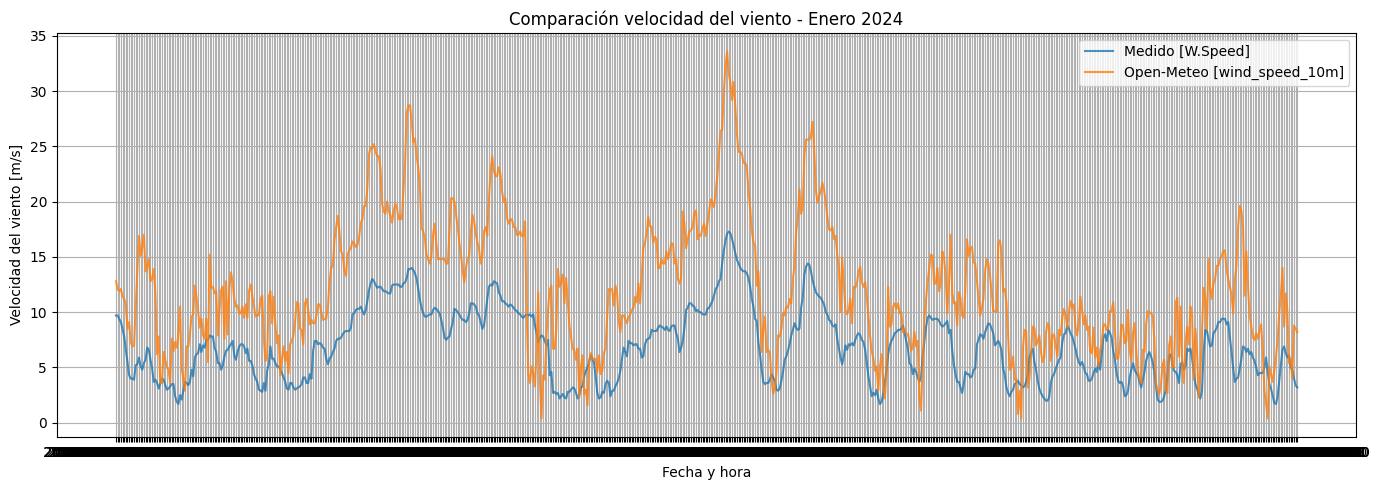

In [ ]:
# Mostrar un mes para no sobrecargar el gráfico
df_sample = df[(df["datetime"] >= "2024-01-01") & (df["datetime"] <= "2024-01-31")]

plt.figure(figsize=(14,5))
plt.plot(df_sample["datetime"], df_sample["W.Speed[m/s]"], label="Medido [W.Speed]", alpha=0.8)
plt.plot(df_sample["datetime"], df_sample["wind_speed_10m"], label="Open-Meteo [wind_speed_10m]", alpha=0.8)
plt.title("Comparación velocidad del viento - Enero 2024")
plt.ylabel("Velocidad del viento [m/s]")
plt.xlabel("Fecha y hora")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
correlacion = df["W.Speed[m/s]"].corr(df["wind_speed_10m"])
print(f"🔗 Correlación entre valores medidos y Open-Meteo: {correlacion:.3f}")

🔗 Correlación entre valores medidos y Open-Meteo: 0.893


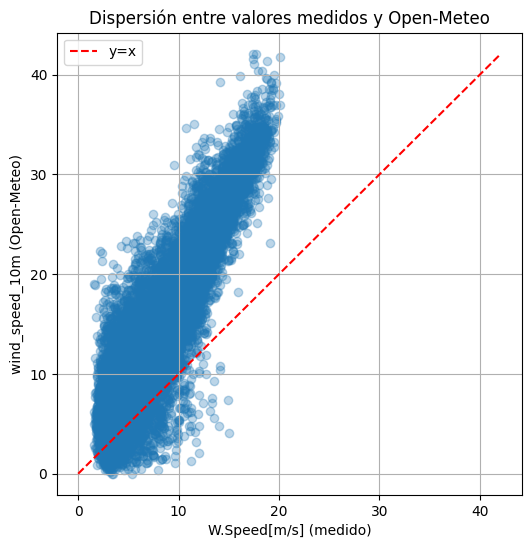

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df["W.Speed[m/s]"], df["wind_speed_10m"], alpha=0.3)
plt.xlabel("W.Speed[m/s] (medido)")
plt.ylabel("wind_speed_10m (Open-Meteo)")
plt.title("Dispersión entre valores medidos y Open-Meteo")
plt.grid(True)
plt.plot([0, df[["W.Speed[m/s]", "wind_speed_10m"]].max().max()],
         [0, df[["W.Speed[m/s]", "wind_speed_10m"]].max().max()],
         'r--', label="y=x")
plt.legend()
plt.show()


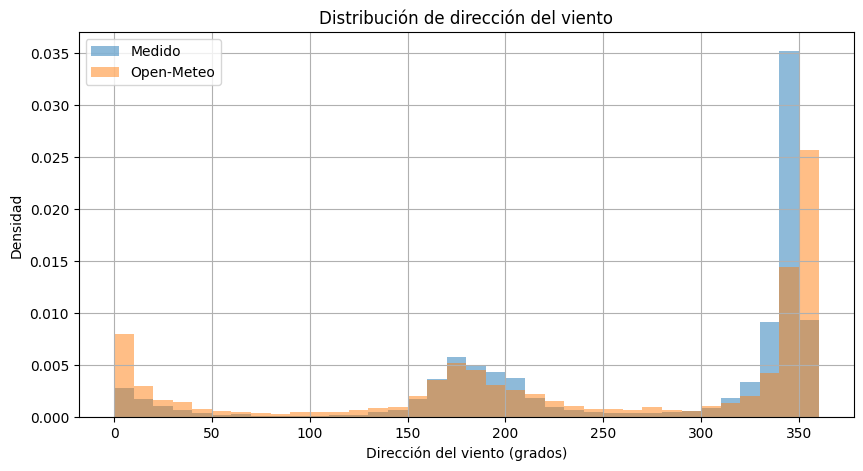

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["W.Direc[deg]"], bins=36, alpha=0.5, label="Medido", density=True)
plt.hist(df["wind_direction_10m"], bins=36, alpha=0.5, label="Open-Meteo", density=True)
plt.xlabel("Dirección del viento (grados)")
plt.ylabel("Densidad")
plt.title("Distribución de dirección del viento")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# Error angular mínimo: distancia circular entre dos ángulos en grados
def angular_error(a1, a2):
    return np.abs(((a1 - a2 + 180) % 360) - 180)

df["error_direccion"] = angular_error(df["W.Direc[deg]"], df["wind_direction_10m"])
mean_error = df["error_direccion"].mean()
median_error = df["error_direccion"].median()

print(f"🧭 Error angular medio: {mean_error:.2f}°")
print(f"🧭 Error angular mediano: {median_error:.2f}°")

🧭 Error angular medio: 20.99°
🧭 Error angular mediano: 10.30°


## Generación de energía PRED ENDE vs real-CNDC

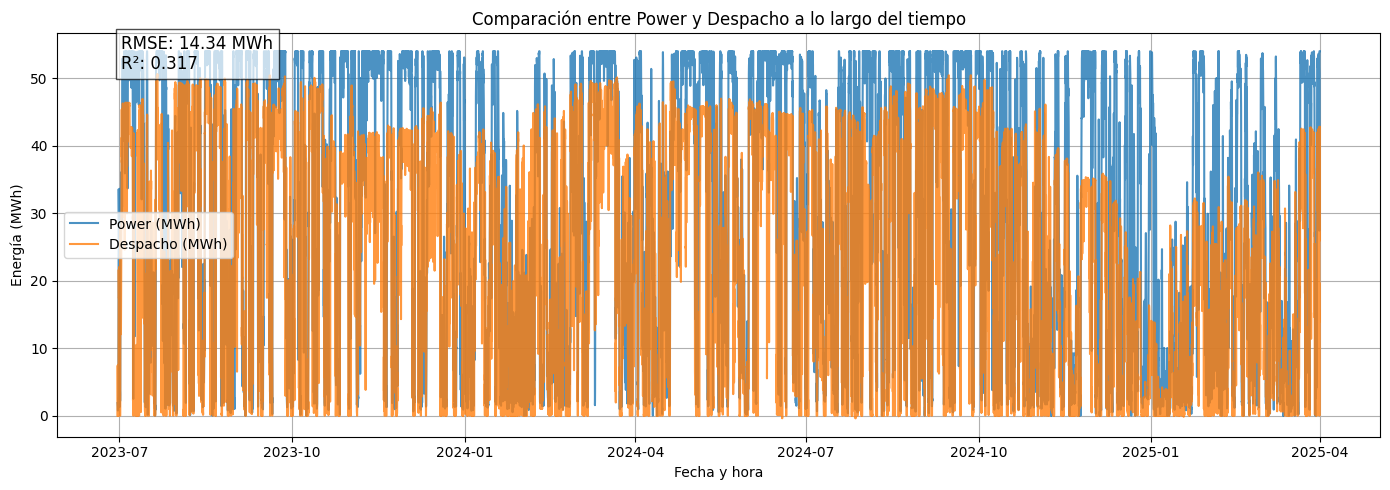

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Asegurar datetime y unidad en MWh
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")  # ✅ Ordenar por fecha para evitar líneas incorrectas
df["Power_MWh"] = df["Power[kWh]"] / 1000

# Calcular métricas
rmse = np.sqrt(mean_squared_error(df["Power_MWh"], df["despacho"]))
r2 = r2_score(df["despacho"], df["Power_MWh"])

# Gráfico con anotaciones
plt.figure(figsize=(14,5))
plt.plot(df["datetime"], df["Power_MWh"], label="Power (MWh)", alpha=0.8)
plt.plot(df["datetime"], df["despacho"], label="Despacho (MWh)", alpha=0.8)
plt.xlabel("Fecha y hora")
plt.ylabel("Energía (MWh)")
plt.title("Comparación entre Power y Despacho a lo largo del tiempo")
plt.legend()
plt.grid(True)

# Anotar RMSE y R²
plt.text(
    df["datetime"].iloc[50],
    max(df["despacho"].max(), df["Power_MWh"].max()) * 0.95,
    f"RMSE: {rmse:.2f} MWh\nR²: {r2:.3f}",
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7)
)

plt.tight_layout()
plt.show()

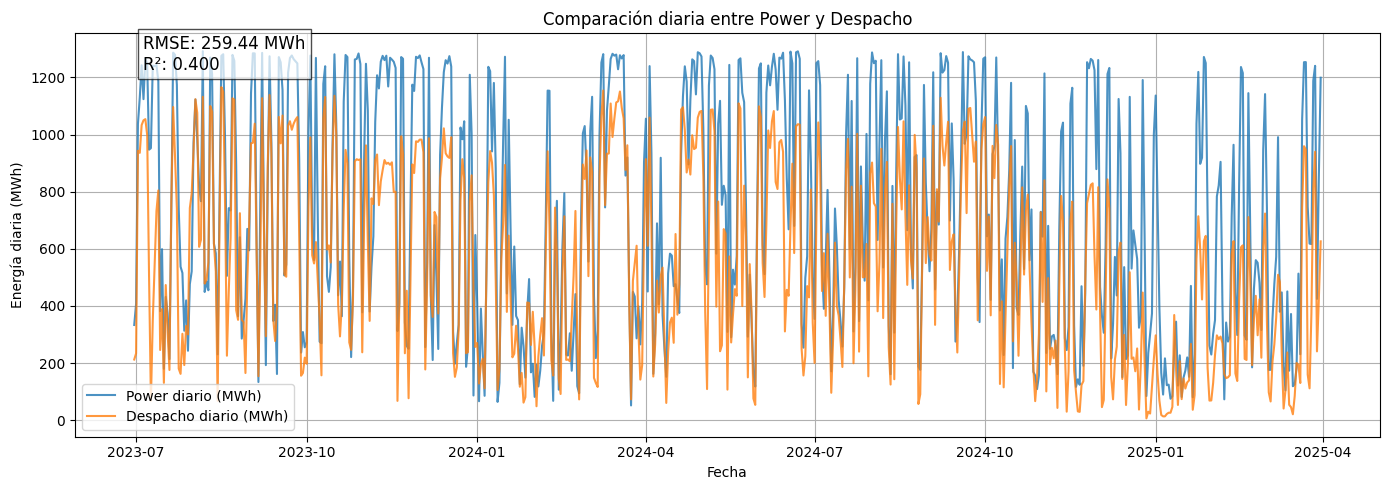

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Asegurar formatos
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")
df["Power_MWh"] = df["Power[kWh]"] / 1000
df["date"] = df["datetime"].dt.date

# Agrupar por día
df_diario = df.groupby("date")[["Power_MWh", "despacho"]].sum().reset_index()

# Calcular métricas
rmse_d = np.sqrt(mean_squared_error(df_diario["Power_MWh"], df_diario["despacho"]))
r2_d = r2_score(df_diario["despacho"], df_diario["Power_MWh"])

# Gráfico diario
plt.figure(figsize=(14,5))
plt.plot(df_diario["date"], df_diario["Power_MWh"], label="Power diario (MWh)", alpha=0.8)
plt.plot(df_diario["date"], df_diario["despacho"], label="Despacho diario (MWh)", alpha=0.8)
plt.xlabel("Fecha")
plt.ylabel("Energía diaria (MWh)")
plt.title("Comparación diaria entre Power y Despacho")
plt.legend()
plt.grid(True)

# Anotar métricas
plt.text(
    df_diario["date"].iloc[5],
    max(df_diario["Power_MWh"].max(), df_diario["despacho"].max()) * 0.95,
    f"RMSE: {rmse_d:.2f} MWh\nR²: {r2_d:.3f}",
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7)
)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Datos horarios ---
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")
df["Power_MWh"] = df["Power[kWh]"] / 1000

rmse_h = np.sqrt(mean_squared_error(df["Power_MWh"], df["despacho"]))
mae_h = mean_absolute_error(df["Power_MWh"], df["despacho"])
r2_h = r2_score(df["despacho"], df["Power_MWh"])
nrmse_h = rmse_h / df["despacho"].mean()

# --- Datos diarios ---
df["date"] = df["datetime"].dt.date
df_diario = df.groupby("date")[["Power_MWh", "despacho"]].sum().reset_index()

rmse_d = np.sqrt(mean_squared_error(df_diario["Power_MWh"], df_diario["despacho"]))
mae_d = mean_absolute_error(df_diario["Power_MWh"], df_diario["despacho"])
r2_d = r2_score(df_diario["despacho"], df_diario["Power_MWh"])
nrmse_d = rmse_d / df_diario["despacho"].mean()

# --- Comparación ---
print("🔍 Comparación de errores")
print(f"RMSE horario : {rmse_h:.2f} MWh")
print(f"MAE horario  : {mae_h:.2f} MWh")
print(f"R² horario   : {r2_h:.3f}")
print(f"nRMSE horario: {nrmse_h:.2%}\n")

print(f"RMSE diario  : {rmse_d:.2f} MWh")
print(f"MAE diario   : {mae_d:.2f} MWh")
print(f"R² diario    : {r2_d:.3f}")
print(f"nRMSE diario : {nrmse_d:.2%}")

🔍 Comparación de errores
RMSE horario : 14.34 MWh
MAE horario  : 10.84 MWh
R² horario   : 0.317
nRMSE horario: 62.51%

RMSE diario  : 259.44 MWh
MAE diario   : 204.19 MWh
R² diario    : 0.400
nRMSE diario : 47.14%


#Distribución de los datos

## Distribución de la generación

In [ ]:
# Asegurar datetime
df["datetime"] = pd.to_datetime(df["datetime"])

# Crear columnas de año y mes
df["Año"] = df["datetime"].dt.year
df["MesNum"] = df["datetime"].dt.month

# Mapear MesNum a nombres en español
mapa_meses = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'
}
df["Mes"] = df["MesNum"].map(mapa_meses)

# Asegurar orden correcto
orden_meses = list(mapa_meses.values())
df["Mes"] = pd.Categorical(df["Mes"], categories=orden_meses, ordered=True)

# Tabla de cantidad de registros por mes y año
tabla_conteo = df.groupby(["Año", "Mes"])["despacho"].count().unstack(fill_value=0)

# Mostrar
print(tabla_conteo)



Mes   Ene  Feb  Mar  Abr  May  Jun  Jul  Ago  Sep  Oct  Nov  Dic
Año                                                             
2023    0    0    0    0    0   24  744  744  720  744  720  744
2024  744  696  744  720  744  720  744  744  720  744  720  744
2025  744  672  744    0    0    0    0    0    0    0    0    0


<ipython-input-15-146e2ce495bf>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla_conteo = df.groupby(["Año", "Mes"])["despacho"].count().unstack(fill_value=0)


<ipython-input-16-76389aef251f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grafico["Mes"] = pd.Categorical(df_grafico["Mes"], categories=orden_meses, ordered=True)


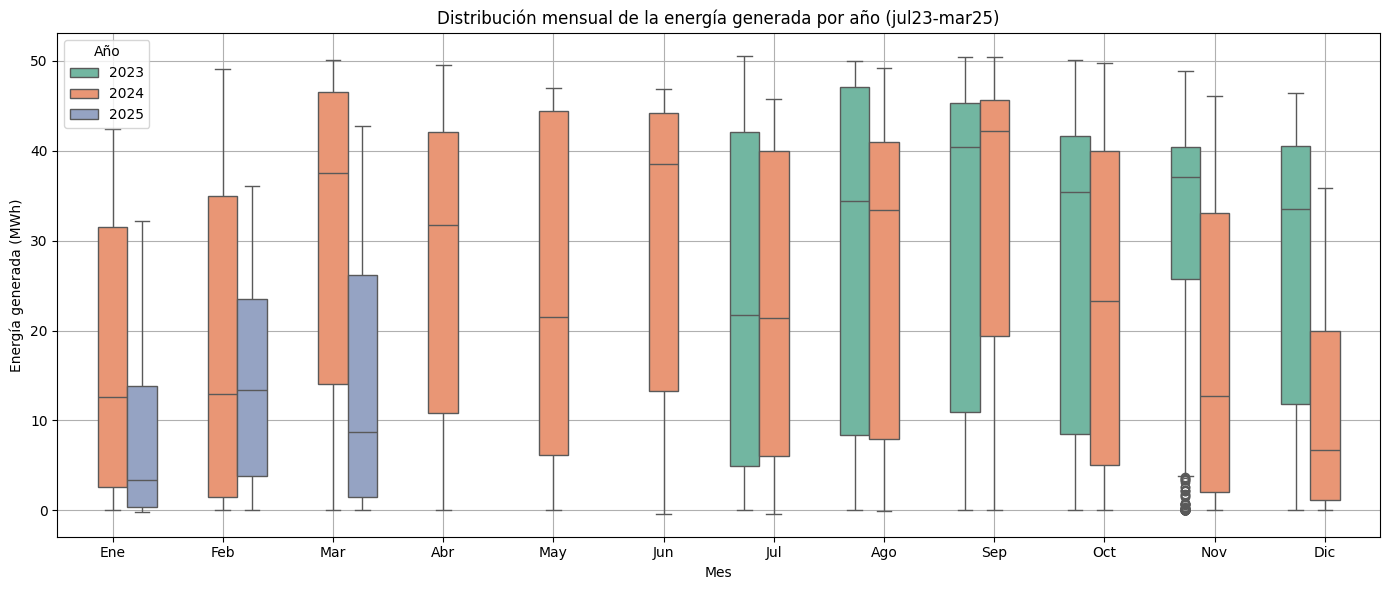

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo para graficar (sin modificar df original)
df_grafico = df[~((df["Año"] == 2023) & (df["Mes"] == "Jun"))]

# Asegurar orden correcto de los meses
orden_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
df_grafico["Mes"] = pd.Categorical(df_grafico["Mes"], categories=orden_meses, ordered=True)

# Boxplot
plt.figure(figsize=(14,6))
sns.boxplot(data=df_grafico, x="Mes", y="despacho", hue="Año", palette="Set2")
plt.title("Distribución mensual de la energía generada por año (jul23-mar25)")
plt.ylabel("Energía generada (MWh)")
plt.xlabel("Mes")
plt.grid(True)
plt.legend(title="Año")
plt.tight_layout()
plt.show()


Aunque la distribución mensual del despacho permite identificar patrones estacionales generales, se observa una variabilidad significativa entre años para un mismo mes, lo que sugiere que el mes del año por sí solo no es un predictor suficiente de la generación energética. Esta dispersión respalda la necesidad de incorporar variables meteorológicas (como velocidad del viento, ráfagas, dirección, presión atmosférica) para mejorar la capacidad predictiva del modelo.”

## Distribución de la velocidad y dirección del viento

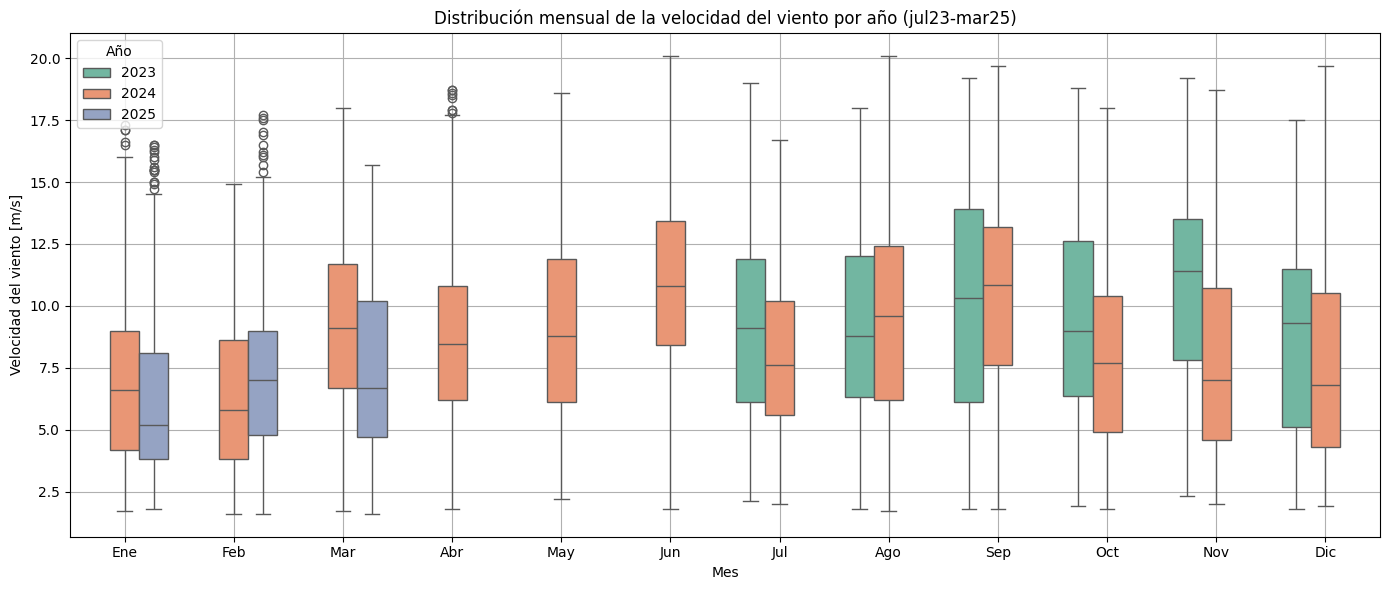

In [ ]:
# Boxplot
plt.figure(figsize=(14,6))
sns.boxplot(data=df_grafico, x="Mes", y="W.Speed[m/s]", hue="Año", palette="Set2")
plt.title("Distribución mensual de la velocidad del viento por año (jul23-mar25)")
plt.ylabel("Velocidad del viento [m/s]")
plt.xlabel("Mes")
plt.grid(True)
plt.legend(title="Año")
plt.tight_layout()
plt.show()

In [ ]:
!pip install windrose

In [ ]:
# Ver columnas y tipos de datos
print("🔎 Columnas y tipos:")
df.info()

🔎 Columnas y tipos:
<class 'pandas.core.frame.DataFrame'>
Index: 15384 entries, 15336 to 15335
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            15384 non-null  int64         
 1   Project Name          15384 non-null  object        
 2   datetime              15384 non-null  datetime64[ns]
 3   Power[kWh]            15384 non-null  float64       
 4   Power_ConfInt10[kWh]  15384 non-null  float64       
 5   Power_ConfInt25[kWh]  15384 non-null  float64       
 6   Power_ConfInt75[kWh]  15384 non-null  float64       
 7   Power_ConfInt90[kWh]  15384 non-null  float64       
 8   W.Speed[m/s]          15384 non-null  float64       
 9   W.Speed P10[m/s]      15384 non-null  float64       
 10  W.Speed P25[m/s]      15384 non-null  float64       
 11  W.Speed P75[m/s]      15384 non-null  float64       
 12  W.Speed P90[m/s]      15384 non-null  float64       
 1

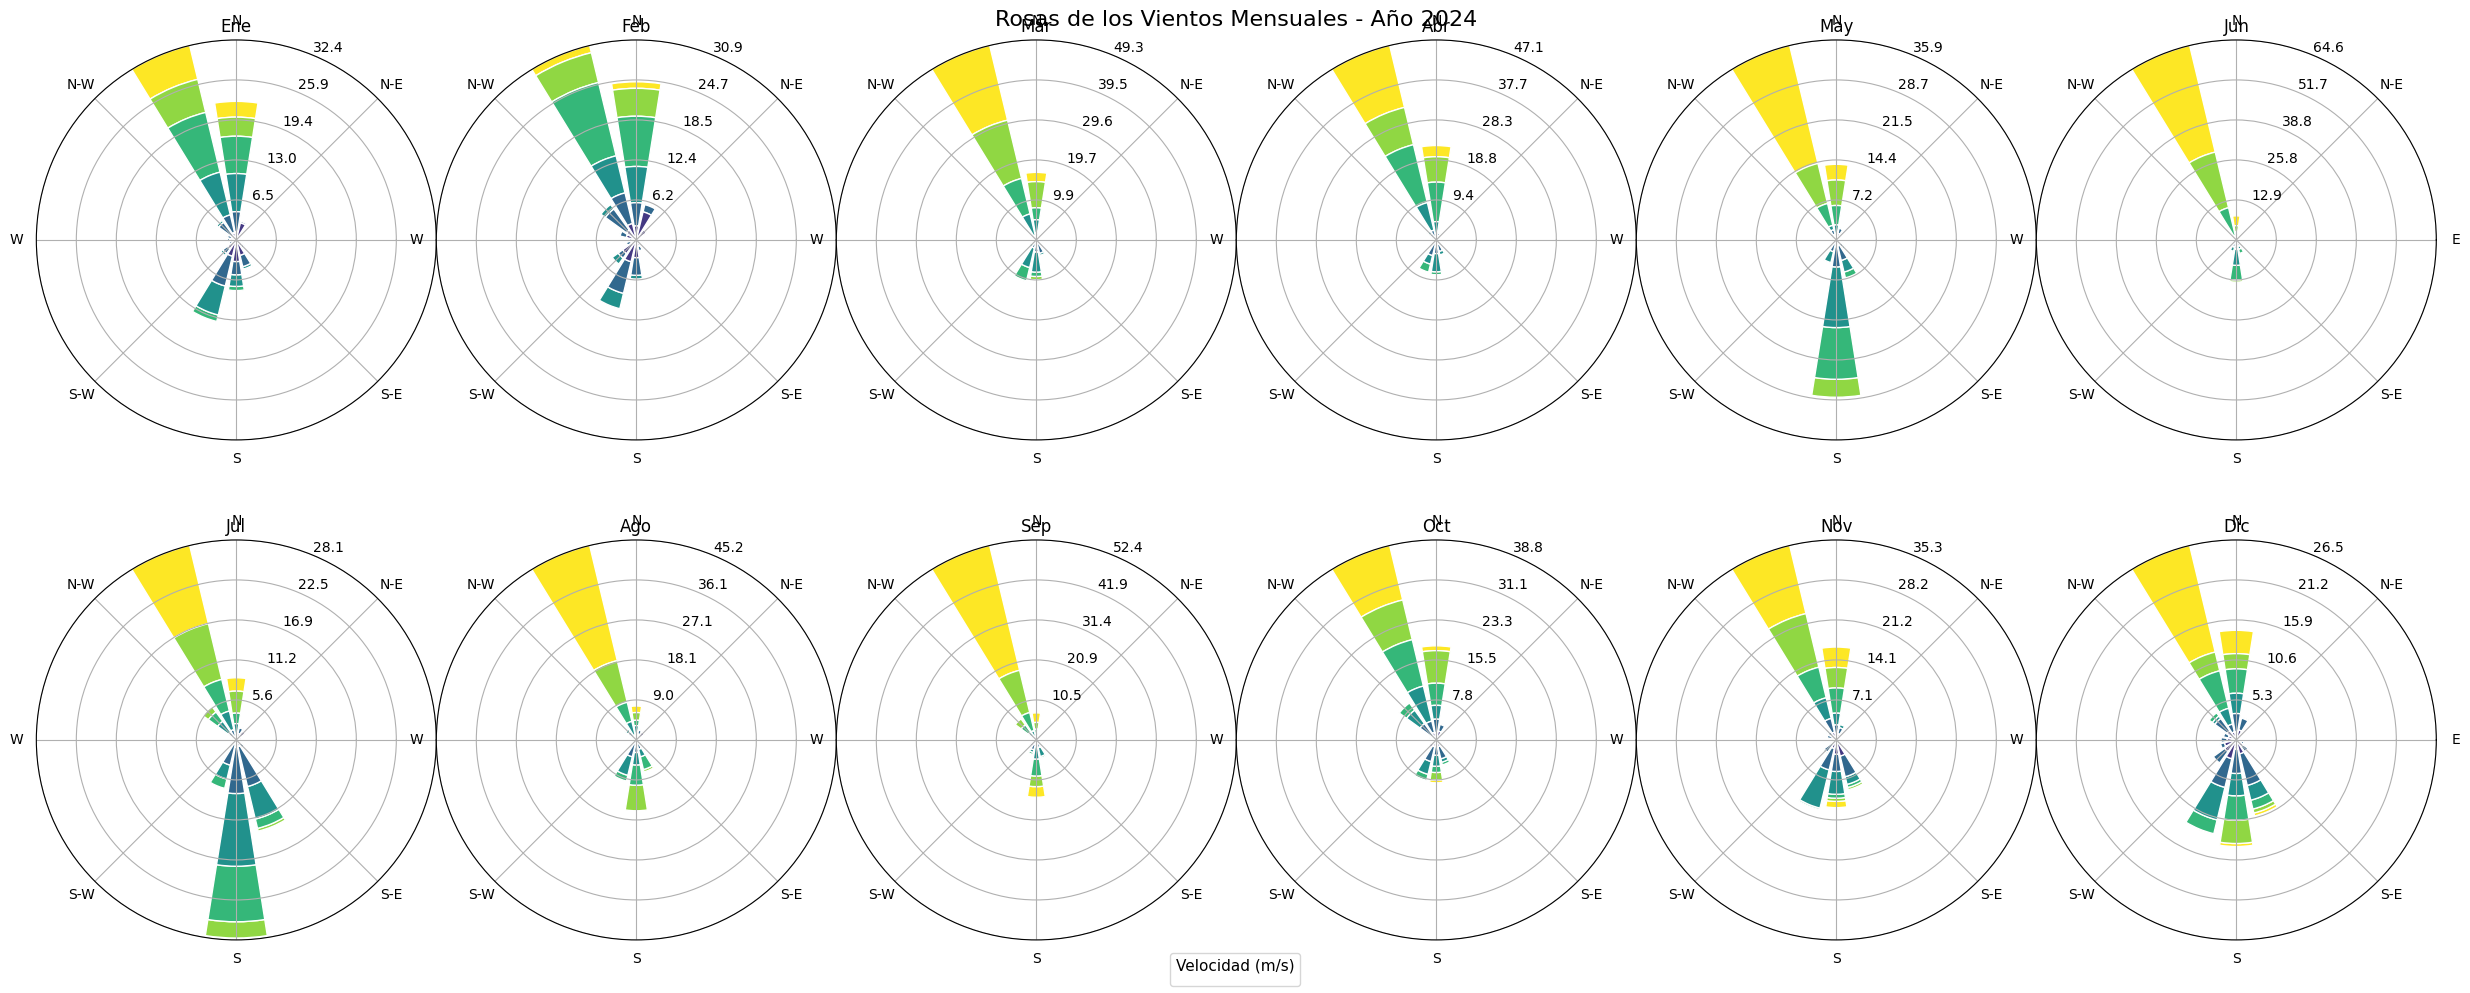

In [ ]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm

# Asegurar orden correcto de los meses
orden_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Filtrar solo año 2024
df_2024 = df[df["Año"] == 2024]

# Bins personalizados para la velocidad
bins = [0.5, 2, 4, 6, 8, 10, 12]

# Crear figura general
fig = plt.figure(figsize=(24, 10))
axes = []

# Loop 12 meses ordenados
for i, mes in enumerate(orden_meses):
    datos_mes = df_2024[df_2024["Mes"] == mes]

    # Coordenadas del subplot
    x0 = (i % 6) * (1 / 6)
    y0 = 0.5 if i < 6 else 0
    rect = [x0, y0, 1 / 6, 0.5]

    # Crear el subplot Windrose
    ax = WindroseAxes.from_ax(fig=fig, rect=rect)
    if not datos_mes.empty:
        ax.bar(datos_mes["W.Direc[deg]"], datos_mes["W.Speed[m/s]"],
               bins=bins, normed=True, opening=0.8, edgecolor='white', cmap=cm.viridis)
    ax.set_title(mes, fontsize=12)
    axes.append(ax)

# Agregar leyenda común (solo si hay al menos un subplot con datos)
if axes:
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Velocidad (m/s)", loc="lower center", ncol=7, fontsize=10, title_fontsize=11)

# Título y ajuste de layout
fig.suptitle("Rosas de los Vientos Mensuales - Año 2024", fontsize=16)
plt.subplots_adjust(top=0.88, bottom=0.12)
plt.show()


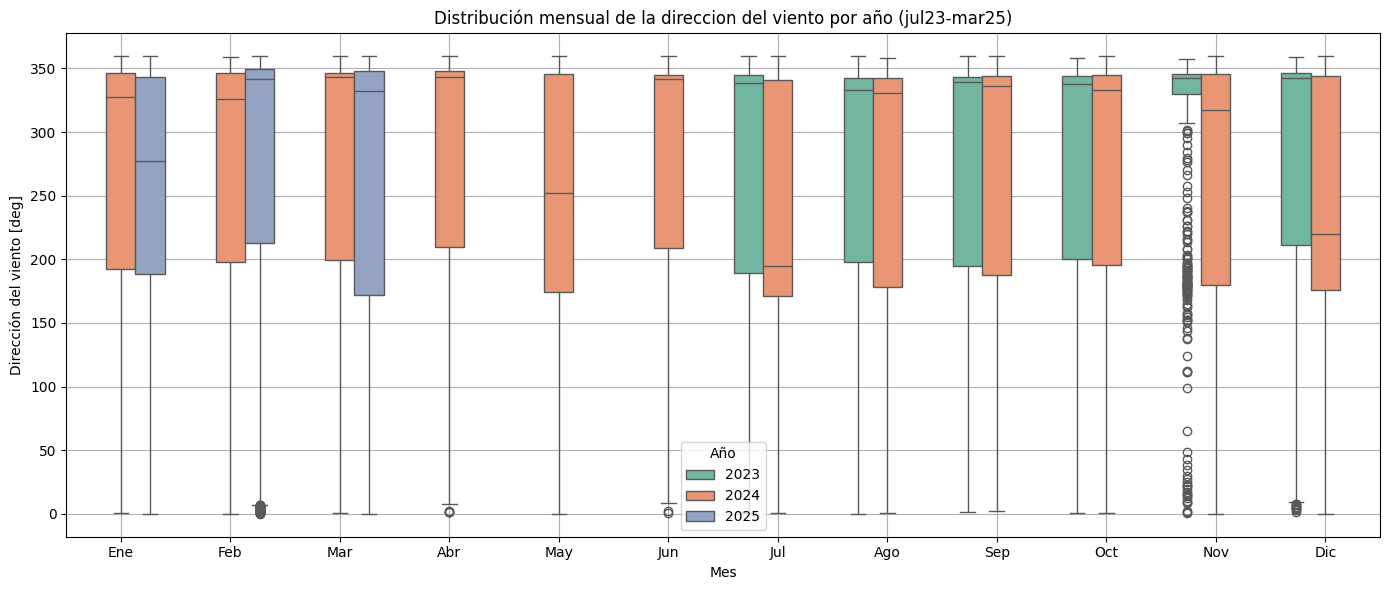

In [ ]:
# Boxplot
plt.figure(figsize=(14,6))
sns.boxplot(data=df_grafico, x="Mes", y="W.Direc[deg]", hue="Año", palette="Set2")
plt.title("Distribución mensual de la direccion del viento por año (jul23-mar25)")
plt.ylabel("Dirección del viento [deg]")
plt.xlabel("Mes")
plt.grid(True)
plt.legend(title="Año")
plt.tight_layout()
plt.show()

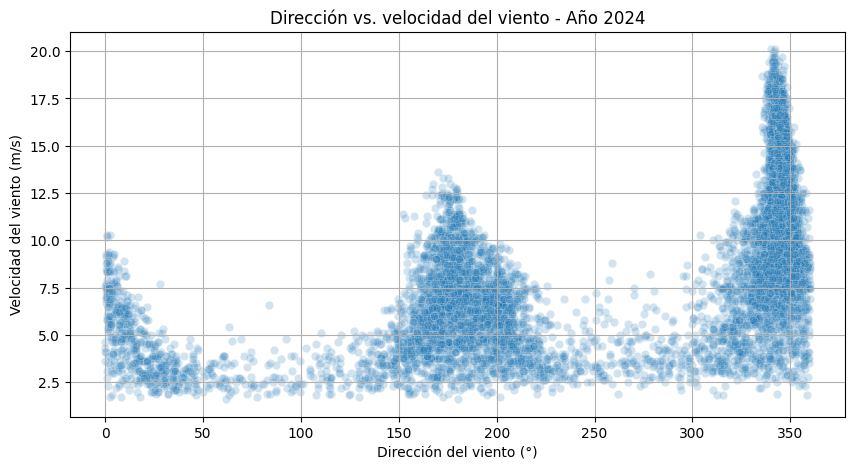

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_2024, x="W.Direc[deg]", y="W.Speed[m/s]", alpha=0.2)
plt.xlabel("Dirección del viento (°)")
plt.ylabel("Velocidad del viento (m/s)")
plt.title("Dirección vs. velocidad del viento - Año 2024")
plt.grid(True)
plt.show()


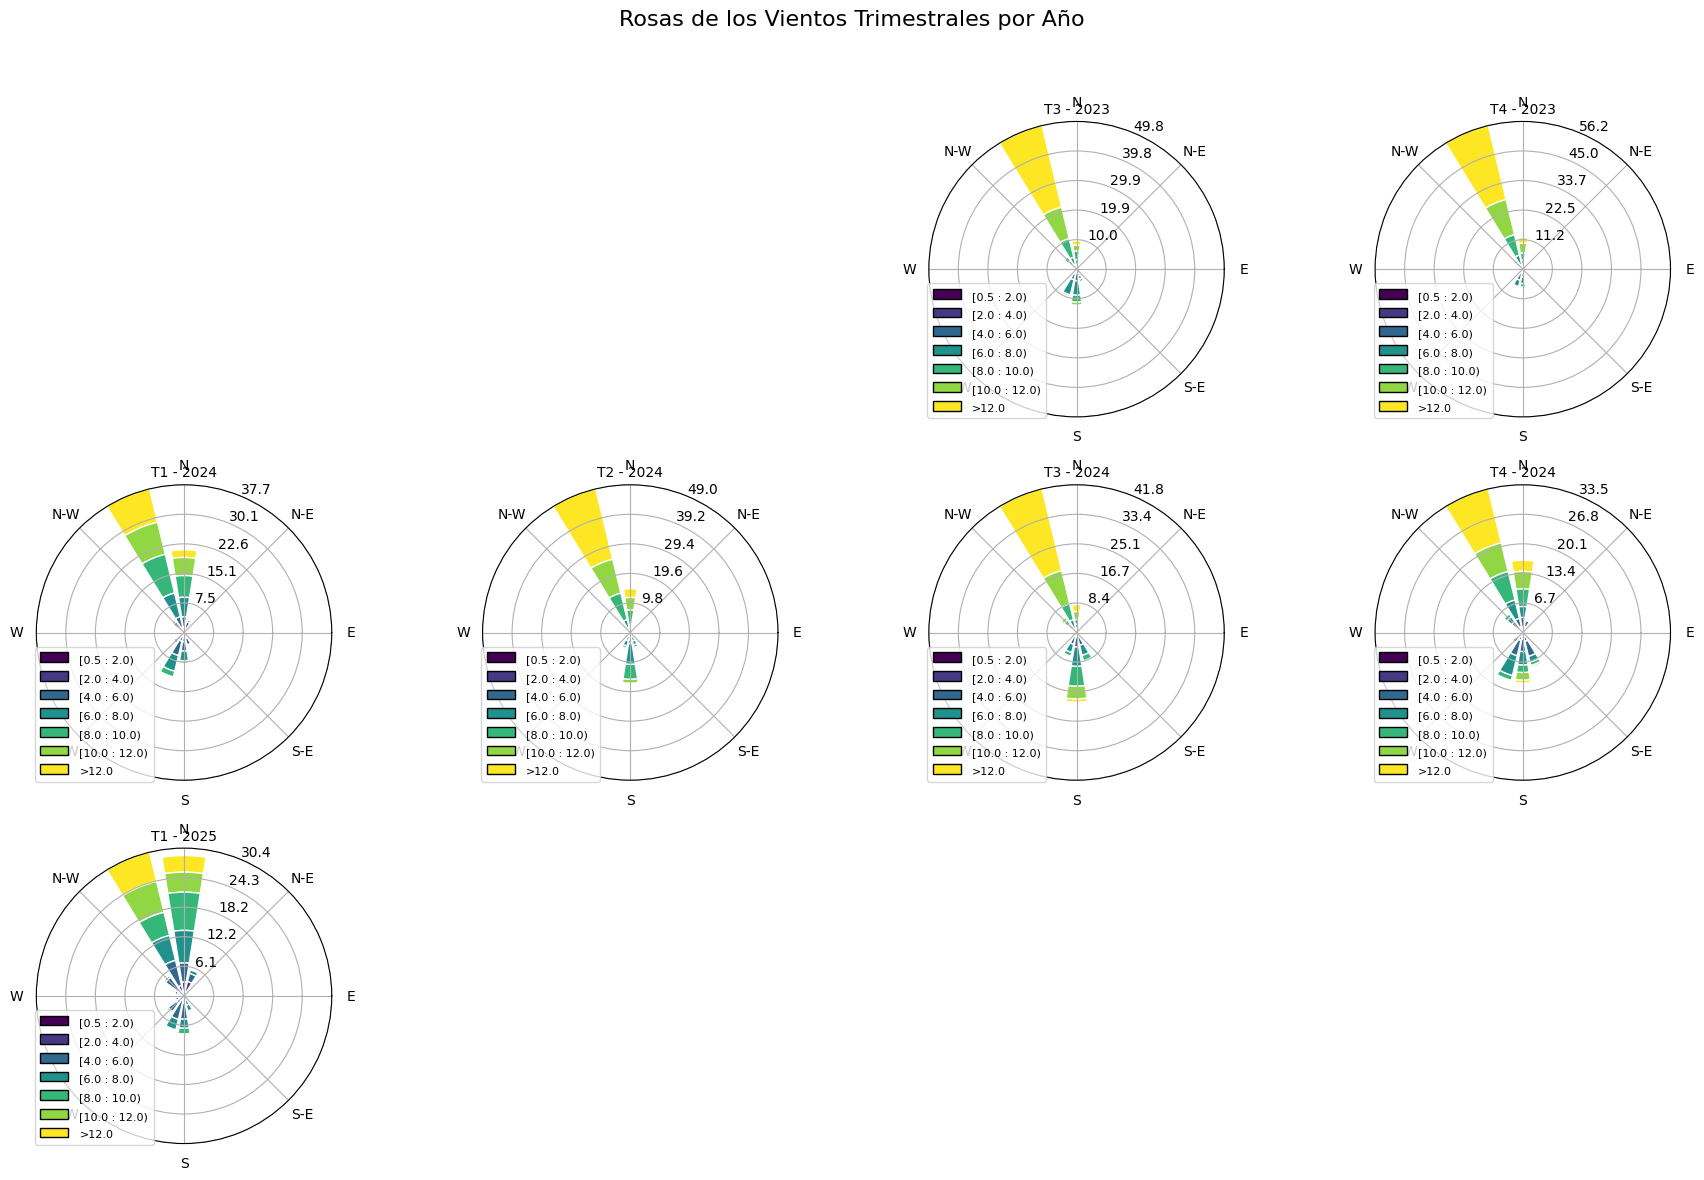

In [ ]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np
import matplotlib.cm as cm

trimestres = {
    "T1": [1, 2, 3],
    "T2": [4, 5, 6],
    "T3": [7, 8, 9],
    "T4": [10, 11, 12]
}

anios = sorted(df["Año"].dropna().unique())

fig = plt.figure(figsize=(18, len(anios) * 4))
fig.suptitle("Rosas de los Vientos Trimestrales por Año", fontsize=16)

for i, anio in enumerate(anios):
    for j, (trimestre, meses) in enumerate(trimestres.items()):
        datos = df[(df["Año"] == anio) & (df["MesNum"].isin(meses))]

        # 🚨 Excluir trimestres con muy pocos datos
        if datos.shape[0] < 50:
            continue

        ax_position = len(trimestres) * i + j + 1
        ax = fig.add_subplot(len(anios), 4, ax_position, projection='windrose')

        ax.bar(datos["W.Direc[deg]"], datos["W.Speed[m/s]"],
               bins=[0.5, 2, 4, 6, 8, 10, 12],
               normed=True, opening=0.8,
               edgecolor='white', cmap=cm.viridis)

        ax.set_legend()
        ax.set_title(f"{trimestre} - {anio}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


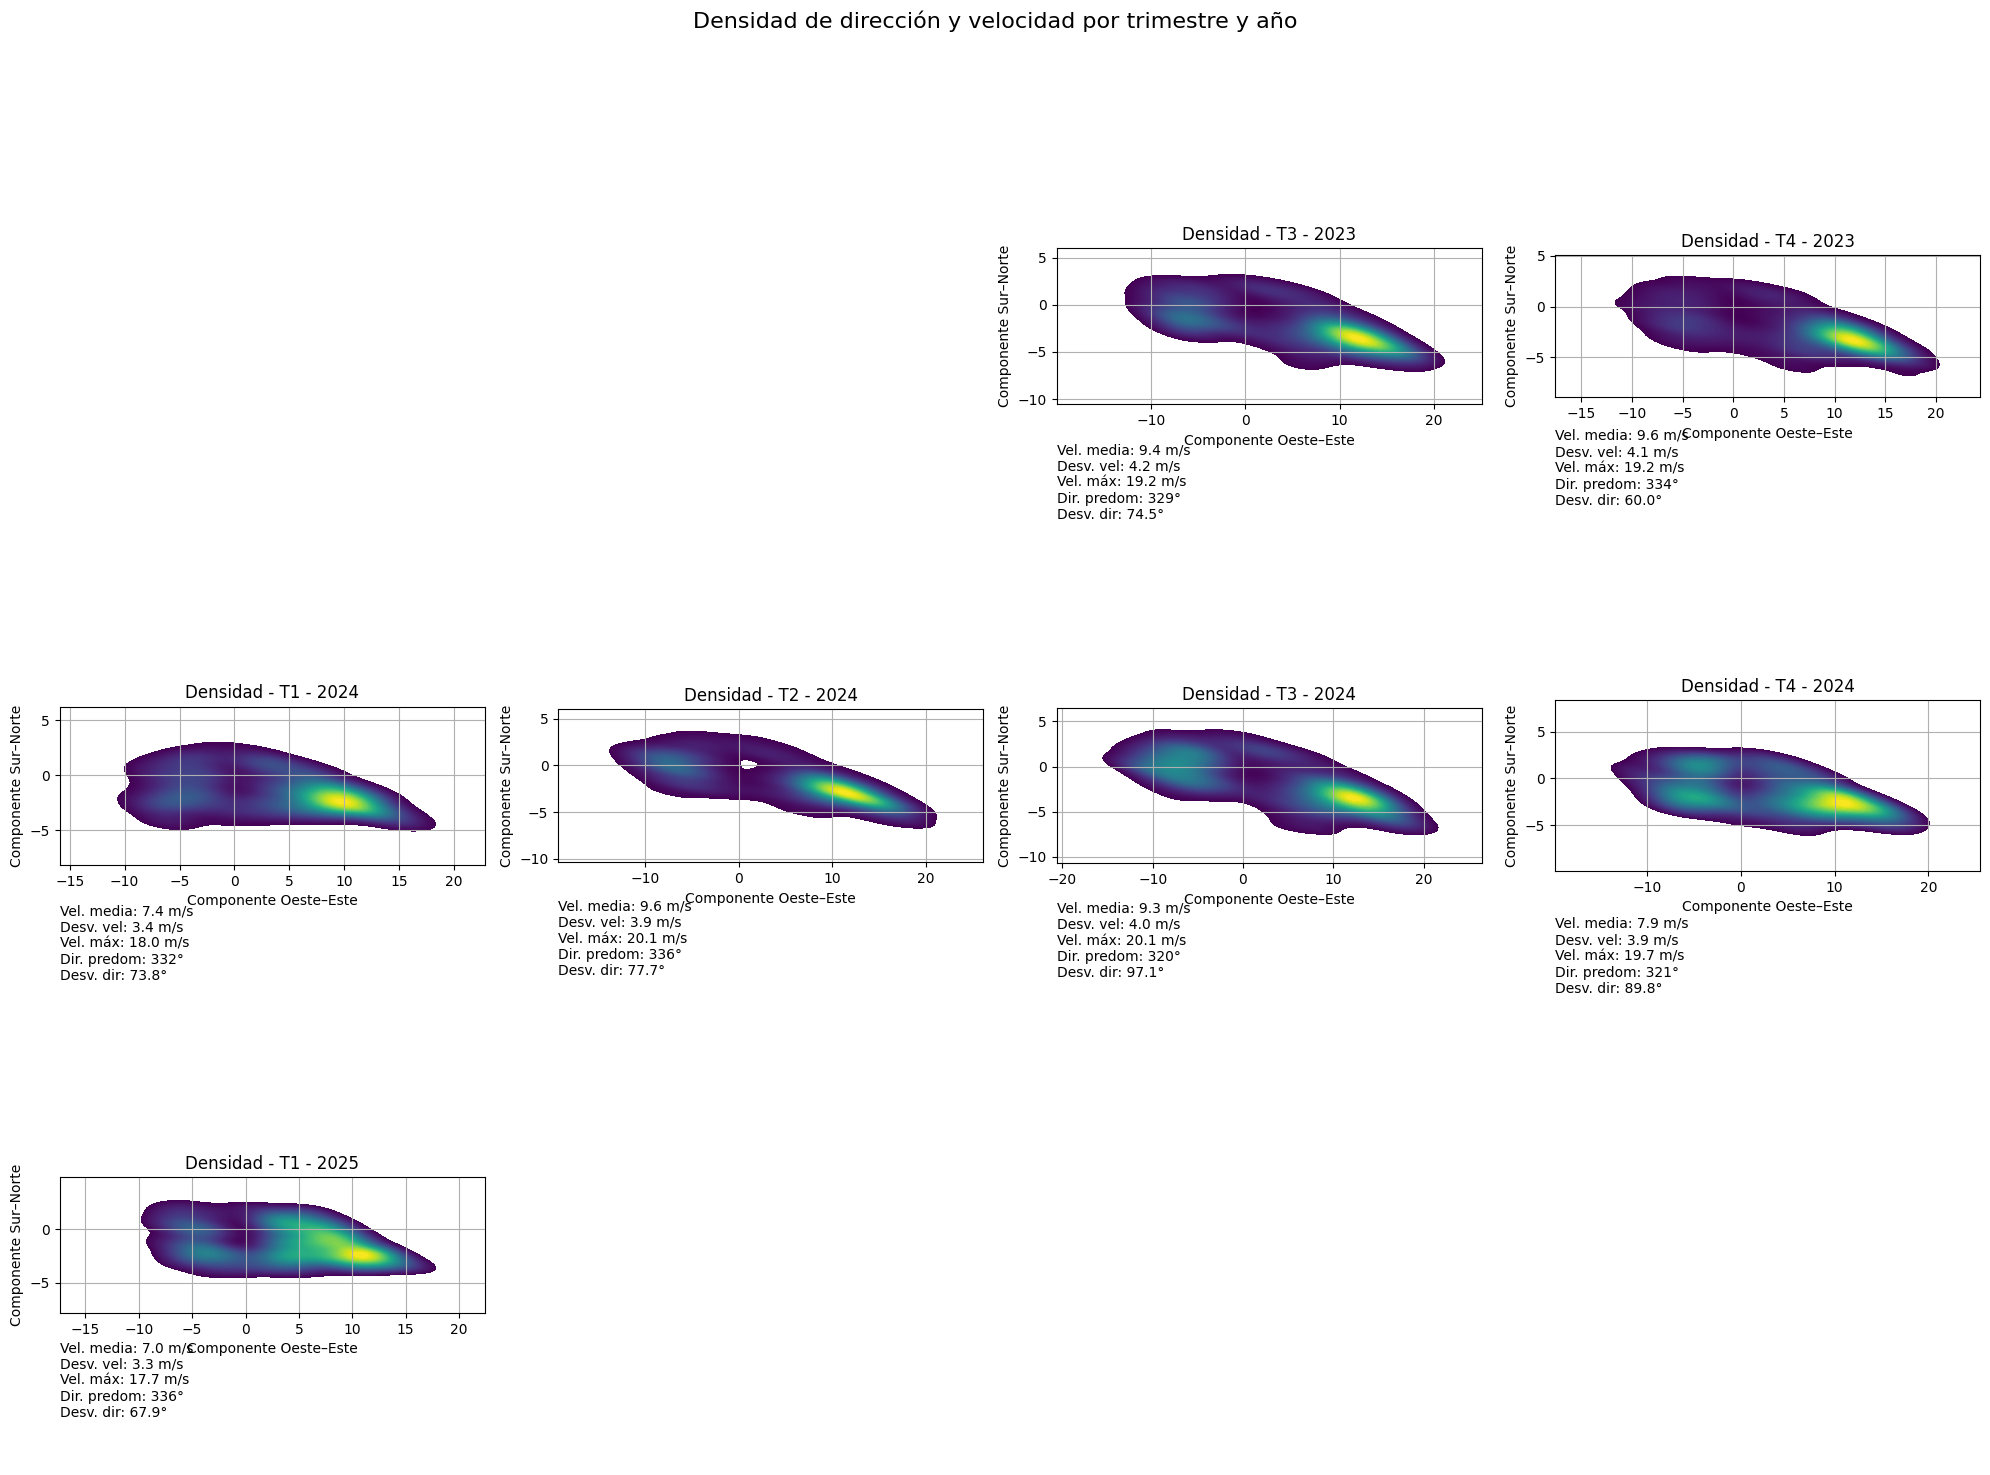

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import circmean

# Crear columna de trimestre
df["Trimestre"] = pd.cut(df["MesNum"], bins=[0, 3, 6, 9, 12],
                         labels=["T1", "T2", "T3", "T4"], include_lowest=True)

# Excluir junio 2023
df_limpio = df[~((df["Año"] == 2023) & (df["MesNum"] == 6))]

# Años y trimestres presentes
anios = sorted(df_limpio["Año"].dropna().unique())
trimestres = ["T1", "T2", "T3", "T4"]

# Crear figura: filas = años, columnas = trimestres
fig, axes = plt.subplots(len(anios), 4, figsize=(20, len(anios) * 5), squeeze=False)

for i, anio in enumerate(anios):
    for j, t in enumerate(trimestres):
        ax = axes[i][j]
        df_trim = df_limpio[(df_limpio["Año"] == anio) & (df_limpio["Trimestre"] == t)]
        df_trim = df_trim[["W.Direc[deg]", "W.Speed[m/s]"]].dropna()

        if df_trim.empty:
            #ax.set_title(f"{t} - {anio} (sin datos)")
            ax.axis('off')
            continue

        # Variables para KDE
        theta = np.deg2rad(df_trim["W.Direc[deg]"])
        r = df_trim["W.Speed[m/s]"]
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        # KDEplot
        sns.kdeplot(x=x, y=y, fill=True, cmap="viridis", levels=100, thresh=0.05, ax=ax)
        ax.set_aspect('equal')
        ax.set_title(f"Densidad - {t} - {anio}")
        ax.set_xlabel("Componente Oeste–Este")
        ax.set_ylabel("Componente Sur–Norte")
        ax.grid(True)

        # 📊 Estadísticas lineales
        vel_media = r.mean()
        vel_std = r.std()
        vel_max = r.max()

        # 🧭 Estadísticas angulares
        dir_pred = circmean(df_trim["W.Direc[deg]"], high=360, low=0)
        theta_rad = np.deg2rad(df_trim["W.Direc[deg]"])
        R = np.sqrt(np.mean(np.cos(theta_rad))**2 + np.mean(np.sin(theta_rad))**2)
        circ_std_deg = np.rad2deg(np.sqrt(-2 * np.log(R)))

        # Mostrar debajo del gráfico (ajustado a la izquierda)
        ax.text(0.0, -0.5,
                f"Vel. media: {vel_media:.1f} m/s\n"
                f"Desv. vel: {vel_std:.1f} m/s\n"
                f"Vel. máx: {vel_max:.1f} m/s\n"
                f"Dir. predom: {dir_pred:.0f}°\n"
                f"Desv. dir: {circ_std_deg:.1f}°",
                ha='left', va='center', transform=ax.transAxes, fontsize=10)

plt.suptitle("Densidad de dirección y velocidad por trimestre y año", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import circmean

# Crear columna de trimestre
df["Trimestre"] = pd.cut(df["MesNum"], bins=[0, 3, 6, 9, 12],
                         labels=["T1", "T2", "T3", "T4"], include_lowest=True)

# Excluir junio 2023
df_limpio = df[~((df["Año"] == 2023) & (df["MesNum"] == 6))]

# Lista para guardar resultados
resumen = []

# Iterar por año y trimestre
for anio in sorted(df_limpio["Año"].unique()):
    for trimestre in ["T1", "T2", "T3", "T4"]:
        datos = df_limpio[(df_limpio["Año"] == anio) & (df_limpio["Trimestre"] == trimestre)]
        datos = datos[["W.Direc[deg]", "W.Speed[m/s]"]].dropna()

        if datos.empty:
            continue

        # Velocidades
        r = datos["W.Speed[m/s]"]
        vel_media = r.mean()
        vel_std = r.std()
        vel_max = r.max()

        # Dirección circular
        dir_pred = circmean(datos["W.Direc[deg]"], high=360, low=0)
        theta_rad = np.deg2rad(datos["W.Direc[deg]"])
        R = np.sqrt(np.mean(np.cos(theta_rad))**2 + np.mean(np.sin(theta_rad))**2)
        circ_std_deg = np.rad2deg(np.sqrt(-2 * np.log(R)))

        resumen.append({
            "Año": anio,
            "Trimestre": trimestre,
            "Vel. media (m/s)": round(vel_media, 1),
            "Vel. máx (m/s)": round(vel_max, 1),
            "Desv. vel (m/s)": round(vel_std, 1),
            "Dir. predom (°)": round(dir_pred, 0),
            "Desv. dir (°)": round(circ_std_deg, 1)
        })

# Crear DataFrame resumen
df_resumen = pd.DataFrame(resumen)

# Mostrar la tabla
import seaborn.objects as so
from IPython.display import display
display(df_resumen)


,Año,Trimestre,Vel. media (m/s),Vel. máx (m/s),Desv. vel (m/s),Dir. predom (°),Desv. dir (°)
0,2023,T3,9.4,19.2,4.2,329.0,74.5
1,2023,T4,9.6,19.2,4.1,334.0,60.0
2,2024,T1,7.4,18.0,3.4,332.0,73.8
3,2024,T2,9.6,20.1,3.9,336.0,77.7
4,2024,T3,9.3,20.1,4.0,320.0,97.1
5,2024,T4,7.9,19.7,3.9,321.0,89.8
6,2025,T1,7.0,17.7,3.3,336.0,67.9


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import circmean

# Crear columna de trimestre numérico
df["TrimestreNum"] = ((df["MesNum"] - 1) // 3 + 1).astype(int)

# Excluir junio 2023
df_limpio = df[~((df["Año"] == 2023) & (df["MesNum"] == 6))]

# Trimestres comparables definidos
pares = [
    (2023, 3, 2024, 3),
    (2023, 4, 2024, 4),
    (2024, 1, 2025, 1)
]

comparaciones = []

for a1, t1, a2, t2 in pares:
    d1 = df_limpio[(df_limpio["Año"] == a1) & (df_limpio["TrimestreNum"] == t1)]
    d2 = df_limpio[(df_limpio["Año"] == a2) & (df_limpio["TrimestreNum"] == t2)]

    if d1.empty or d2.empty:
        continue

    nombre_comparacion = f"T{t1} - {a1} vs {a2}"

    for datos, año, trimestre in [(d1, a1, t1), (d2, a2, t2)]:
        datos = datos[["W.Direc[deg]", "W.Speed[m/s]"]].dropna()

        r = datos["W.Speed[m/s]"]
        theta_rad = np.deg2rad(datos["W.Direc[deg]"])

        vel_media = r.mean()
        vel_max = r.max()
        vel_std = r.std()
        dir_pred = circmean(datos["W.Direc[deg]"], high=360, low=0)
        R = np.sqrt(np.mean(np.cos(theta_rad))**2 + np.mean(np.sin(theta_rad))**2)
        circ_std_deg = np.rad2deg(np.sqrt(-2 * np.log(R)))

        comparaciones.append({
            "Comparación": nombre_comparacion,
            "Año": año,
            "Trimestre": f"T{trimestre}",
            "Vel. media (m/s)": round(vel_media, 1),
            "Vel. máx (m/s)": round(vel_max, 1),
            "Desv. vel (m/s)": round(vel_std, 1),
            "Dir. predom (°)": round(dir_pred, 0),
            "Desv. dir (°)": round(circ_std_deg, 1)
        })

# Mostrar la tabla
df_comparacion = pd.DataFrame(comparaciones)
display(df_comparacion)


,Comparación,Año,Trimestre,Vel. media (m/s),Vel. máx (m/s),Desv. vel (m/s),Dir. predom (°),Desv. dir (°)
0,T3 - 2023 vs 2024,2023,T3,9.4,19.2,4.2,329.0,74.5
1,T3 - 2023 vs 2024,2024,T3,9.3,20.1,4.0,320.0,97.1
2,T4 - 2023 vs 2024,2023,T4,9.6,19.2,4.1,334.0,60.0
3,T4 - 2023 vs 2024,2024,T4,7.9,19.7,3.9,321.0,89.8
4,T1 - 2024 vs 2025,2024,T1,7.4,18.0,3.4,332.0,73.8
5,T1 - 2024 vs 2025,2025,T1,7.0,17.7,3.3,336.0,67.9


## Distribución de la temperatura, presión y humedad

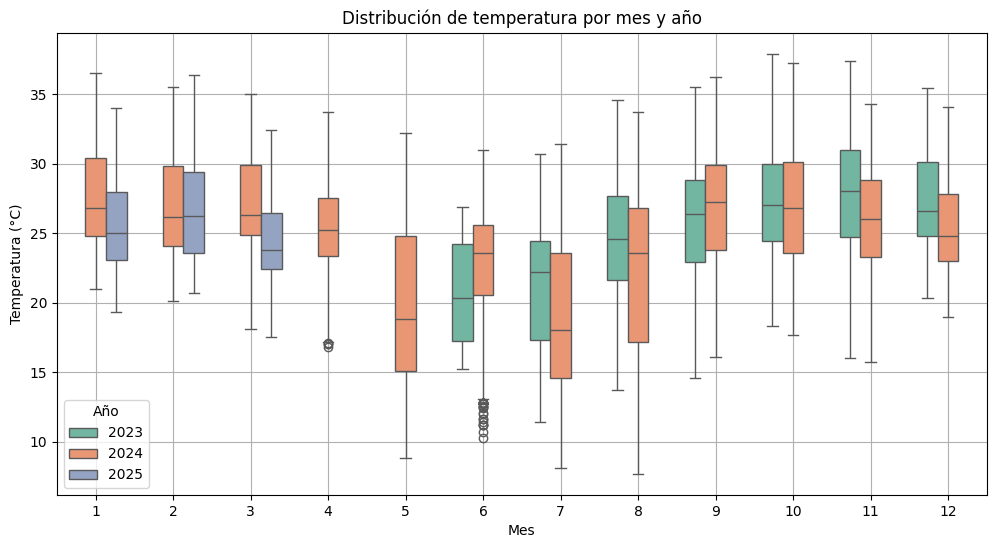

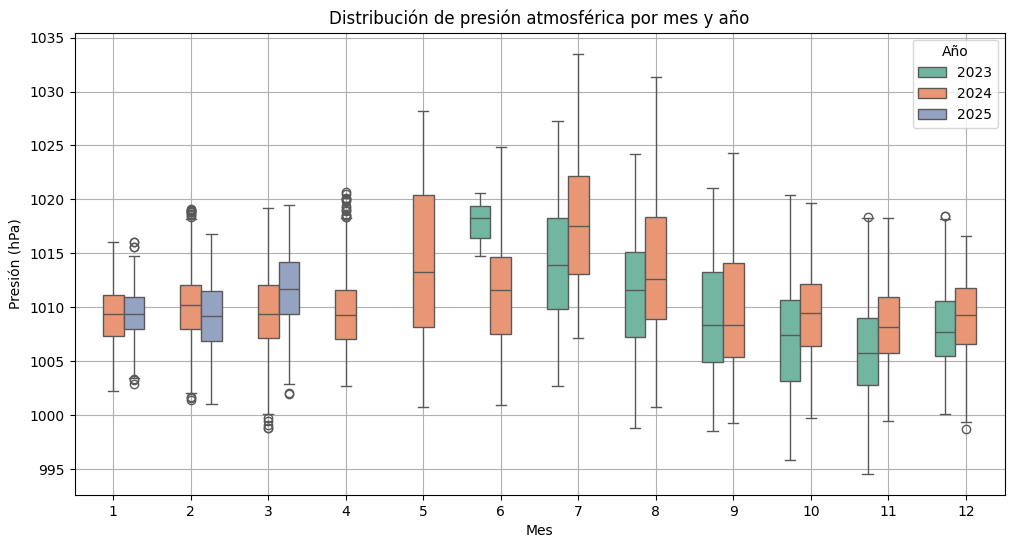

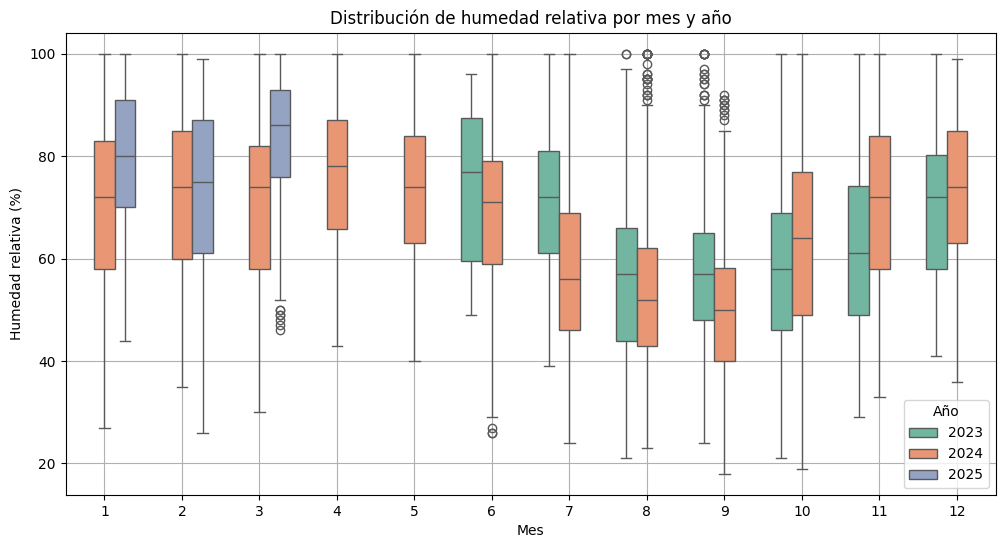

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="MesNum", y="temperature_2m", hue="Año", palette="Set2")
plt.title("Distribución de temperatura por mes y año")
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()

# PLOT 1: Presión atmosférica
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="MesNum", y="pressure_msl", hue="Año", palette="Set2")
plt.title("Distribución de presión atmosférica por mes y año")
plt.xlabel("Mes")
plt.ylabel("Presión (hPa)")
plt.grid(True)
plt.show()

# PLOT 2: Humedad relativa
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="MesNum", y="relative_humidity_2m", hue="Año", palette="Set2")
plt.title("Distribución de humedad relativa por mes y año")
plt.xlabel("Mes")
plt.ylabel("Humedad relativa (%)")
plt.grid(True)
plt.show()


#Relación entre variables

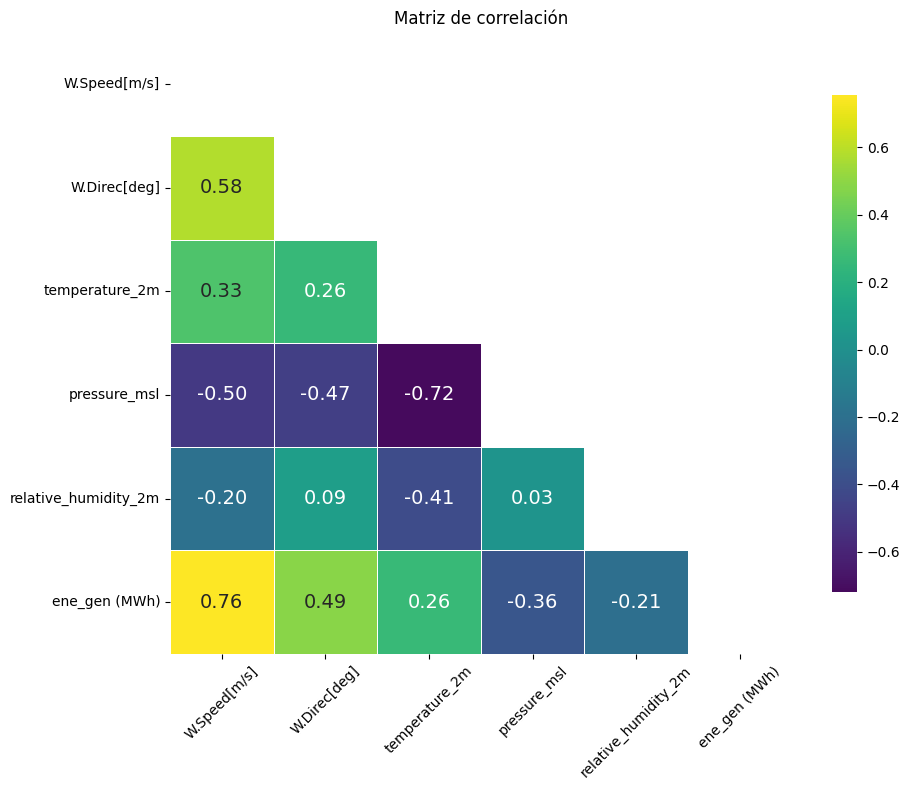

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Renombrar despacho
df_ren = df.rename(columns={"despacho": "ene_gen (MWh)"})

# Variables seleccionadas
variables = [
    "W.Speed[m/s]",
    "W.Direc[deg]",
    "temperature_2m",
    "pressure_msl",
    "relative_humidity_2m",
    "ene_gen (MWh)"
]

# Calcular matriz de correlación
df_corr = df_ren[variables].dropna()
corr = df_corr.corr()

# Crear máscara para ocultar la parte superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Graficar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="viridis",
    center=0,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 14}
)
plt.title("Matriz de correlación")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


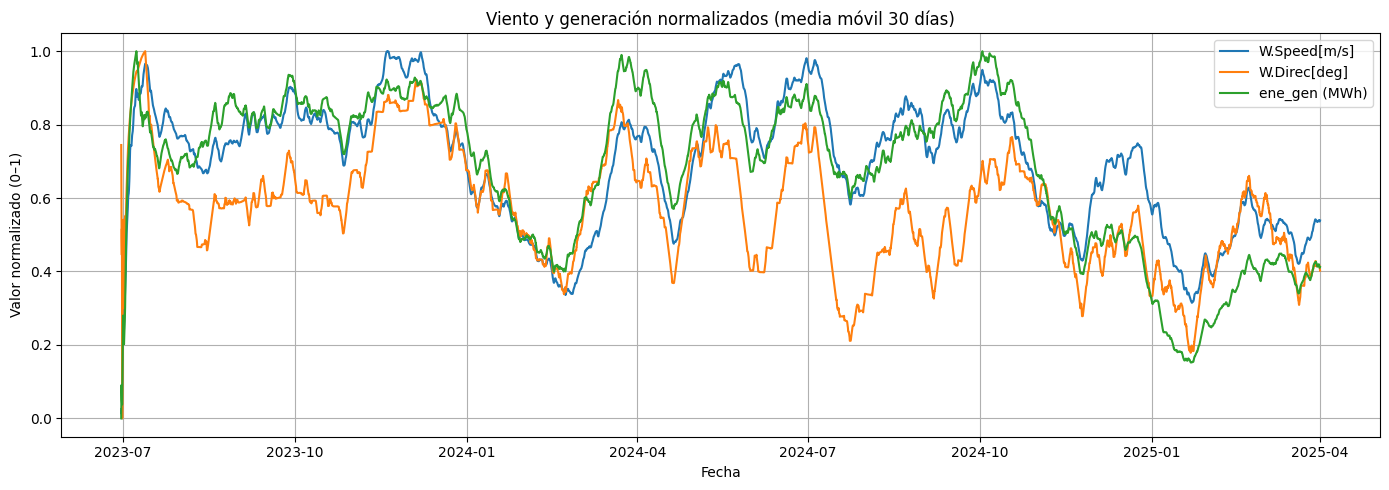

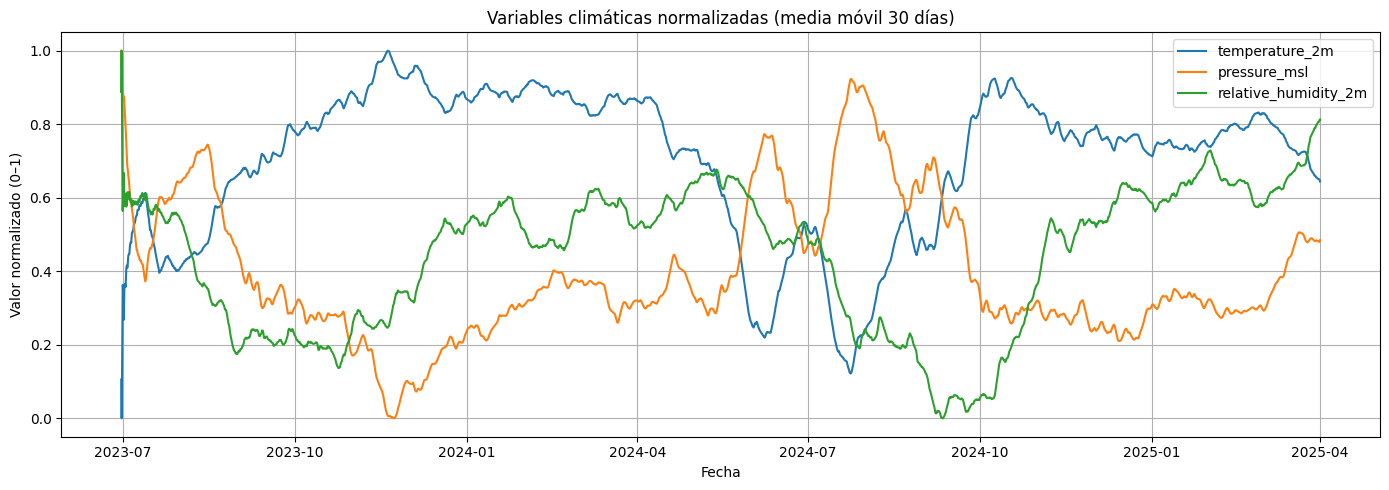

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Variables por grupo (renombramos despacho para visualización)
viento_gen = ["W.Speed[m/s]", "W.Direc[deg]", "despacho"]
clima = ["temperature_2m", "pressure_msl", "relative_humidity_2m"]

# Preparar datos
df_sorted = df.sort_values("datetime").copy()
df_sorted["datetime"] = pd.to_datetime(df_sorted["datetime"])
df_sorted.set_index("datetime", inplace=True)

# Rolling de 30 días
df_rolling = df_sorted[viento_gen + clima].rolling("30D").mean().dropna()

# Renombrar para graficar
df_viento_ren = df_rolling[viento_gen].rename(columns={"despacho": "ene_gen (MWh)"})
df_clima = df_rolling[clima]

# Normalización
df_norm_viento = pd.DataFrame(
    MinMaxScaler().fit_transform(df_viento_ren),
    columns=df_viento_ren.columns,
    index=df_rolling.index
)
df_norm_clima = pd.DataFrame(
    MinMaxScaler().fit_transform(df_clima),
    columns=clima,
    index=df_rolling.index
)

# Panel 1: viento y generación
plt.figure(figsize=(14, 5))
for var in df_norm_viento.columns:
    plt.plot(df_norm_viento.index, df_norm_viento[var], label=var)
plt.title("Viento y generación normalizados (media móvil 30 días)")
plt.ylabel("Valor normalizado (0–1)")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Panel 2: clima
plt.figure(figsize=(14, 5))
for var in df_norm_clima.columns:
    plt.plot(df_norm_clima.index, df_norm_clima[var], label=var)
plt.title("Variables climáticas normalizadas (media móvil 30 días)")
plt.ylabel("Valor normalizado (0–1)")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
